In [3]:
# !pip install openpyxl

In [1]:
from xmip.utils import google_cmip_col
from xmip.preprocessing import combined_preprocessing
from xmip.postprocessing import concat_experiments, pick_first_member, _drop_duplicate_grid_labels #TODO:  _drop_duplicate_grid_labels should be public?

In [28]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

In [3]:
col = google_cmip_col()
col

In [5]:
source_ids = [s for s in sorted(col.df['source_id'].unique()) if s not in ['AWI-CM-1-1-MR','AWI-ESM-1-1-LR']] # exclude unstructured grids

In [6]:
query = dict(
    variable_id='tos',
    experiment_id=['historical', 'ssp245'], 
    table_id='Omon', 
    require_all_on=['source_id', 'grid_label', 'member_id']
)
cat = col.search(source_id=source_ids, **query)
cat

In [7]:
# Loading all these datasets into xarray takes long, but not prohibitively long (few minutes). 
# As a more perfomant option one could work some pandas magic and select members based on availability of both experiments, and filter out grid_labels.
# For this purpose Ill take the slightly longer loading time.

# Could look something like this:
# def prune_members(df):
#     return df.iloc[0]

# df = cat.df
# pruned_df = df.groupby([c for c in df.columns if c not in ['member_id', 'zstore', 'dcpp_init_year']], group_keys=False, as_index=False).apply(prune_members)
# cat.esmcat._df = pruned_df
# cat

ddict = cat.to_dataset_dict(aggregate=False, preprocess=combined_preprocessing, skip_on_error=True, )


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/preprocessing.py:96: UserWarning: ScenarioMIP.MIROC.MIROC6.ssp245.r8i1p1f1.Omon.gn.none.tos:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double check results.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/preprocessing.py:96: UserWarning: ScenarioMIP.MIROC.MIROC6.ssp245.r8i1p1f1.Omon.gn.none.tos:While renaming to target `lat_bounds`, more than one candidate was found ['y_bnds', 'vertices_latitude']. Renaming y_bnds to lat_bounds. Please double check results.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r15i1p1f2.Omon.gn.none.tos:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double check results.
  warnings.

In [8]:
# One of the models has the dimensions i/j labelled differently(incorrectly? See https://github.com/jbusecke/xMIP/issues/311 for discussion)
ddict_fixed = {name:ds.rename({'x':'y', 'y':'x'}) if 'CMCC' in ds.attrs['source_id'] else ds for name, ds in ddict.items()}

In [9]:
# Postprocessing steps: Concat experiments, pick only first member and pick only one grid label (regridded preferred)
ddict_concat = concat_experiments(ddict_fixed)
ddict_first = pick_first_member(ddict_concat)
ddict_pruned = _drop_duplicate_grid_labels(ddict_first, 'gr')

/srv/conda/envs/notebook/lib/python3.10/site-packages/xmip/postprocessing.py:89: UserWarning: Match attributes ['experiment_id'] not found in any of the datasets.         This can happen when several combination functions are used and attributes are removed during merging.         Double check the results.
  warnings.warn(


In [10]:
# there is a double entry for EC-Earth
# TODO: investigate why
# for now quick fix
ddict_pruned = {k:ds for k,ds in ddict_pruned.items() if k not in ['EC-Earth3.Omon.r101i1p1f1.tos.tos']}

In [11]:
sorted(list(ddict_pruned.keys()))

['ACCESS-CM2.Omon.r1i1p1f1.tos.tos',
 'BCC-CSM2-MR.Omon.r1i1p1f1.tos.tos',
 'CAMS-CSM1-0.Omon.r1i1p1f1.tos.tos',
 'CESM2-WACCM.Omon.r1i1p1f1.tos.tos',
 'CESM2.Omon.r10i1p1f1.tos.tos',
 'CIESM.Omon.r1i1p1f1.tos.tos',
 'CMCC-CM2-SR5.Omon.r1i1p1f1.tos.tos',
 'CMCC-ESM2.Omon.r1i1p1f1.tos.tos',
 'CNRM-CM6-1-HR.Omon.r1i1p1f2.tos.tos',
 'CNRM-CM6-1.Omon.r10i1p1f2.tos.tos',
 'CNRM-ESM2-1.Omon.r10i1p1f2.tos.tos',
 'CanESM5-CanOE.Omon.r1i1p2f1.tos.tos',
 'CanESM5.Omon.r10i1p1f1.tos.tos',
 'EC-Earth3-CC.Omon.r1i1p1f1.tos.tos',
 'EC-Earth3-Veg-LR.Omon.r1i1p1f1.tos.tos',
 'EC-Earth3-Veg.Omon.r2i1p1f1.tos.tos',
 'EC-Earth3.Omon.r10i1p1f1.tos.tos',
 'FGOALS-f3-L.Omon.r1i1p1f1.tos.tos',
 'FGOALS-g3.Omon.r1i1p1f1.tos.tos',
 'FIO-ESM-2-0.Omon.r1i1p1f1.tos.tos',
 'GFDL-CM4.Omon.r1i1p1f1.tos.tos',
 'GFDL-ESM4.Omon.r1i1p1f1.tos.tos',
 'GISS-E2-1-G.Omon.r10i1p1f2.tos.tos',
 'HadGEM3-GC31-LL.Omon.r1i1p1f3.tos.tos',
 'IITM-ESM.Omon.r1i1p1f1.tos.tos',
 'INM-CM4-8.Omon.r1i1p1f1.tos.tos',
 'INM-CM5-0.Omon.r1i1p1

In [13]:
# Cut to the time frame desired (1990-2019)
ddict_time_selected = {k:ds.sel(time=slice('1990', '2019')) for k,ds in ddict_pruned.items()}
# make sure all the datasets have the same length in time
assert len(set([len(ds.time) for ds in ddict_time_selected.values()])) == 1

In [14]:
# load all datasets into memory to speed this up
from tqdm.auto import tqdm

ddict_loaded = {}
for k, ds in tqdm(ddict_time_selected.items()):
    print(k)
    ddict_loaded[k] = ds.load()

  0%|          | 0/40 [00:00<?, ?it/s]

FGOALS-g3.Omon.r1i1p1f1.tos.tos
CanESM5-CanOE.Omon.r1i1p2f1.tos.tos
CNRM-CM6-1.Omon.r10i1p1f2.tos.tos
CanESM5.Omon.r10i1p1f1.tos.tos
GFDL-ESM4.Omon.r1i1p1f1.tos.tos
CMCC-CM2-SR5.Omon.r1i1p1f1.tos.tos
NESM3.Omon.r1i1p1f1.tos.tos
MIROC6.Omon.r10i1p1f1.tos.tos
MIROC-ES2L.Omon.r10i1p1f2.tos.tos
FIO-ESM-2-0.Omon.r1i1p1f1.tos.tos
CNRM-ESM2-1.Omon.r10i1p1f2.tos.tos
IPSL-CM6A-LR.Omon.r10i1p1f1.tos.tos
CESM2-WACCM.Omon.r1i1p1f1.tos.tos
EC-Earth3-Veg.Omon.r2i1p1f1.tos.tos
FGOALS-f3-L.Omon.r1i1p1f1.tos.tos
EC-Earth3.Omon.r10i1p1f1.tos.tos
MCM-UA-1-0.Omon.r1i1p1f2.tos.tos
CAMS-CSM1-0.Omon.r1i1p1f1.tos.tos
GISS-E2-1-G.Omon.r10i1p1f2.tos.tos
HadGEM3-GC31-LL.Omon.r1i1p1f3.tos.tos
MPI-ESM1-2-LR.Omon.r10i1p1f1.tos.tos
INM-CM4-8.Omon.r1i1p1f1.tos.tos
KACE-1-0-G.Omon.r1i1p1f1.tos.tos
CESM2.Omon.r10i1p1f1.tos.tos
EC-Earth3-Veg-LR.Omon.r1i1p1f1.tos.tos
UKESM1-0-LL.Omon.r1i1p1f2.tos.tos
CIESM.Omon.r1i1p1f1.tos.tos
MRI-ESM2-0.Omon.r1i1p1f1.tos.tos
ACCESS-CM2.Omon.r1i1p1f1.tos.tos
NorESM2-MM.Omon.r1i1p1f1.tos

In [35]:
# compute the linear trend
import xarray as xr

def calculate_linear_trend(ds):
    attrs = ds.attrs
    da = ds.tos.squeeze().load()
    coeffs = da.polyfit('time', 1)
    # evaluate trend coefficients
    trend = xr.polyval(ds.time, coeffs.polyfit_coefficients)
    # compute the linear trend difference between beginning and end
    diff = trend.isel(time=[0,-1]).diff('time').squeeze()
    diff = diff.assign_coords({k:ds[k] for k in ['lon', 'lat']})
    diff.attrs = attrs
    return diff

ddict_trends = {}
for k, ds in tqdm(ddict_loaded.items()):
    ddict_trends[k] = calculate_linear_trend(ds).to_dataset(name = 'cumulative_tos_trend')

  0%|          | 0/40 [00:00<?, ?it/s]

In [36]:
# Last step: Interpolate the trend maps on a commmon grid
# NOTE: I could have done this before, and then taken the linear trend, but this should be a lot more efficient.
import xesmf as xe

target_grid = xe.util.grid_global(1, 1) # interpolate on regular 1 deg grid. 
# Might want to put this to a higher res as some models have higher native resolution
# and we might be aliasing.
# But should be ok for a first take
datasets = []
for model, ds in tqdm(ddict_trends.items()):
    # make sure only lon/lat have values
    ds = ds.drop([dim for dim in ['x', 'y', 'longitude', 'latitude'] if dim in ds.dims])

    # fix datasets with wrapped array boundaries(these cause stripes in the regridded data)
    if len(ds.x) == 362:
        print(f"Clip Halo for {model}")
        ds = ds.isel(x=slice(1,-1))

    regridder = xe.Regridder(
        ds,
        target_grid,
        method='bilinear',
        periodic=True,
        ignore_degenerate=True, 
        unmapped_to_nan=True,
        extrap_method='nearest_s2d',
    )
    ds_regridded = regridder(ds).assign_coords(model=model.split('.')[0])
    datasets.append(ds_regridded)

  0%|          | 0/40 [00:00<?, ?it/s]

Clip Halo for CNRM-CM6-1.Omon.r10i1p1f2.tos.tos


/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Clip Halo for CMCC-CM2-SR5.Omon.r1i1p1f1.tos.tos
Clip Halo for NESM3.Omon.r1i1p1f1.tos.tos
Clip Halo for CNRM-ESM2-1.Omon.r10i1p1f2.tos.tos
Clip Halo for IPSL-CM6A-LR.Omon.r10i1p1f1.tos.tos
Clip Halo for EC-Earth3-Veg.Omon.r2i1p1f1.tos.tos
Clip Halo for EC-Earth3-Veg-LR.Omon.r1i1p1f1.tos.tos
Clip Halo for EC-Earth3-CC.Omon.r1i1p1f1.tos.tos
Clip Halo for CMCC-ESM2.Omon.r1i1p1f1.tos.tos


In [37]:
datasets[0]

<xarray.Dataset>
Dimensions:               (y: 180, x: 360)
Coordinates:
    time                  object 2019-12-16 12:00:00
    lat                   (y, x) float64 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon                   (y, x) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
    model                 <U9 'FGOALS-g3'
Dimensions without coordinates: y, x
Data variables:
    cumulative_tos_trend  (y, x) float64 nan nan nan ... 0.003979 0.003991
Attributes:
    regrid_method:  bilinear

In [38]:
ds_merged = xr.concat(datasets, dim='model').drop('time')
ds_merged

<xarray.Dataset>
Dimensions:               (model: 40, y: 180, x: 360)
Coordinates:
    lat                   (y, x) float64 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon                   (y, x) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * model                 (model) <U16 'FGOALS-g3' ... 'IITM-ESM'
Dimensions without coordinates: y, x
Data variables:
    cumulative_tos_trend  (model, y, x) float64 nan nan nan nan ... nan nan nan
Attributes:
    regrid_method:  bilinear

## Test plots for each model

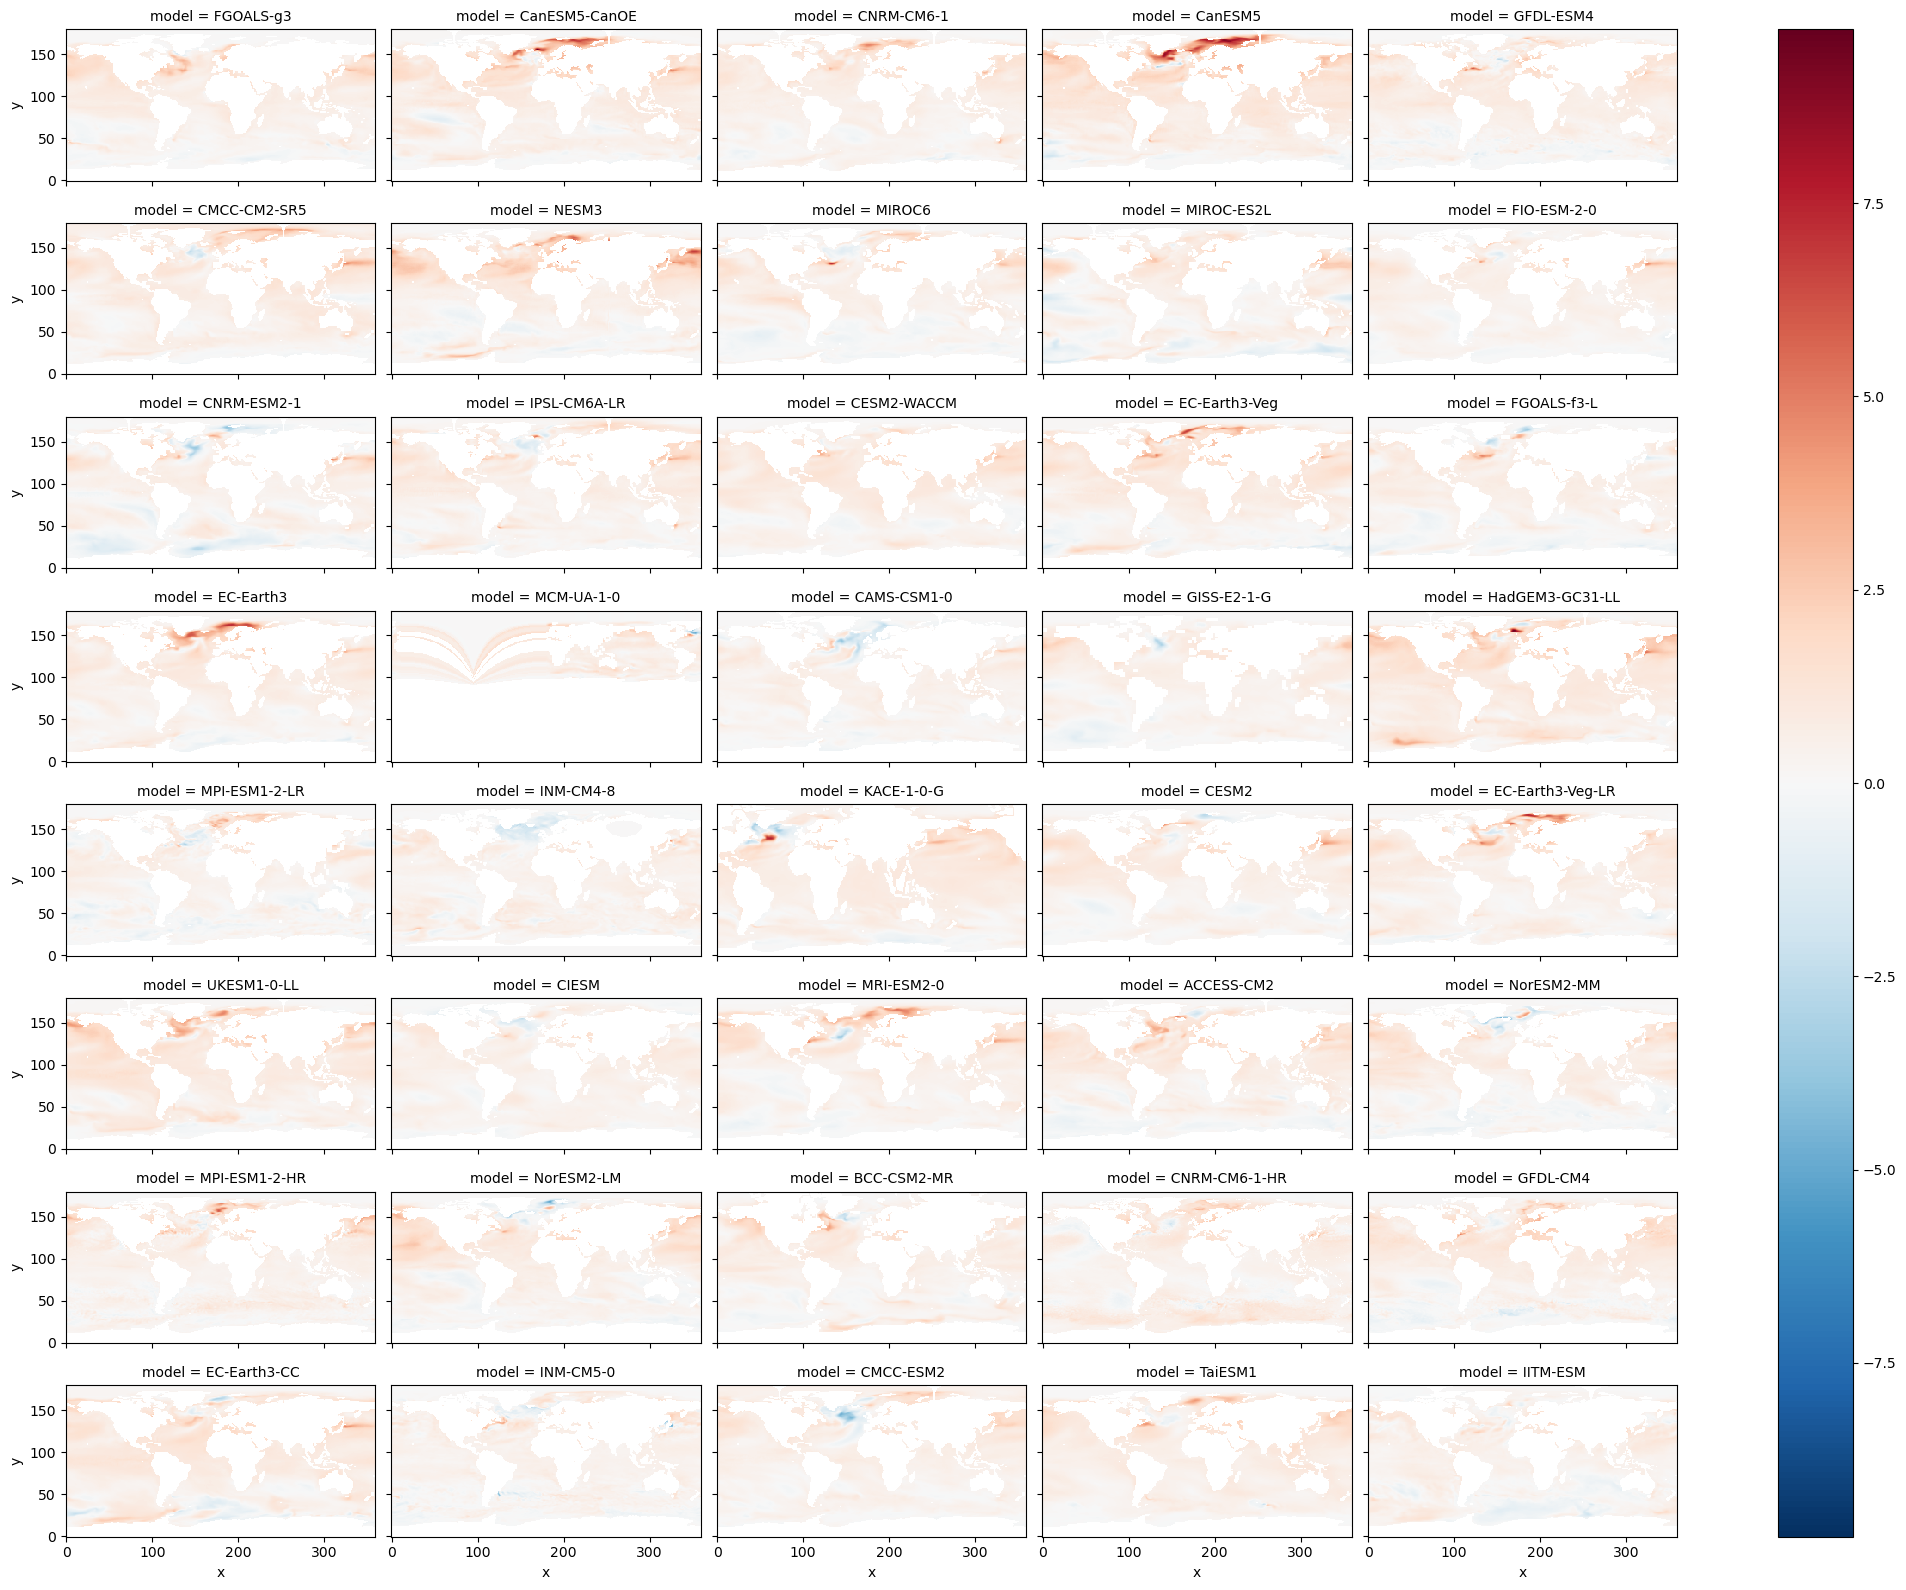

In [25]:
ds_merged.plot(col='model', col_wrap=5, aspect=2, size=2)

# Investigation of failed regridding cases:
- `MCM-UA-1-0` has faulty lat values (range[0-90] only)
- `KACE-1-0-G` has shifted lon values:
<div>
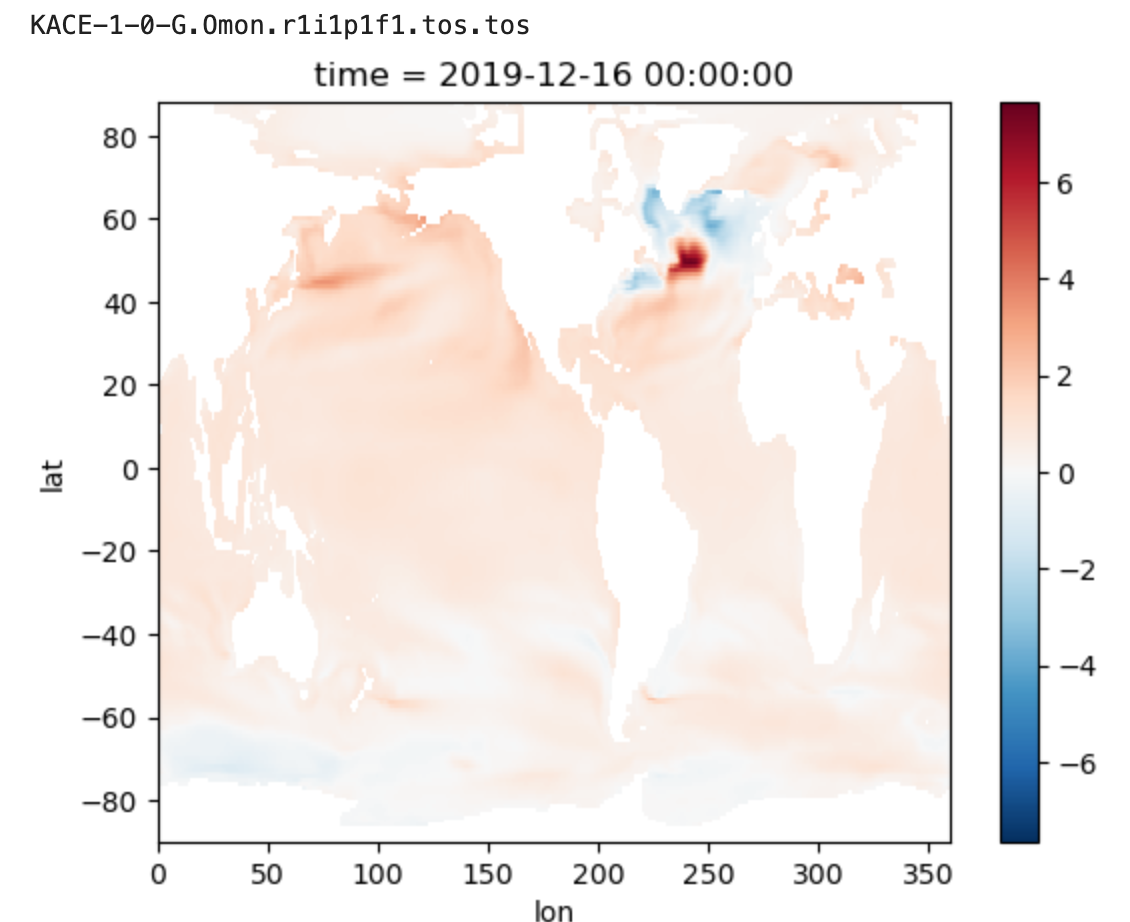
</div>

> This was the same for all members of `KACE-1-0-G`

These might be fixable, but for now Ill just exclude them from the final product.

## Remove 'MCM-UA-1-0' and 'KACE-1-0-G'

In [39]:
ds_merged_clean = ds_merged.sel(model = [m for m in ds_merged.model.data if m not in ['MCM-UA-1-0', 'KACE-1-0-G']])
ds_merged_clean

<xarray.Dataset>
Dimensions:               (model: 38, y: 180, x: 360)
Coordinates:
    lat                   (y, x) float64 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon                   (y, x) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * model                 (model) <U16 'FGOALS-g3' ... 'IITM-ESM'
Dimensions without coordinates: y, x
Data variables:
    cumulative_tos_trend  (model, y, x) float64 nan nan nan nan ... nan nan nan
Attributes:
    regrid_method:  bilinear

## Add likely/very_likely ECR/TCS screening from Hausfather et al. 2022

In [41]:
# Load supplemental data of Hausfather et al. 2022 (https://www.nature.com/articles/d41586-022-01192-2)
df = pd.read_excel('https://zenodo.org/record/6476375/files/Hausfather%20et%20al%20Nature%202022%20supporting%20data.xlsx?download=1', nrows=60, skiprows=0)

hausfather_et_al_models = df.iloc[1:-1,0].tolist()
print(f"Missing Models in this study: {set(hausfather_et_al_models)- set(ds_merged_clean.model.data)}")
print('---------------------------------')

for li, label in enumerate(['tcr_likely', 'tcr_very_likely', 'ecs_likely', 'ecs_very_likely']):
    
    values = df.iloc[1:-1, li+4].tolist()
    values = [v =='Y' for v in values]
    model_value_dict = {m:v for m,v in zip(hausfather_et_al_models, values)}
    
    coord_values = []
    ds_models = ds_merged_clean.model.data
    for m in ds_models:
        coord_values.append(model_value_dict[m])
         
    ds_merged_clean = ds_merged_clean.assign_coords({label:('model', coord_values)})
ds_merged_clean

Missing Models in this study: {'CAS-ESM2-0', 'CESM2-WACCM-FV2', 'MIROC-ES2H', 'E3SM-1-1', 'MCM-UA-1-0', 'E3SM-1-0', 'ACCESS-ESM1-5', 'KIOST-ESM', 'NorCPM1', 'MPI-ESM-1-2-HAM', 'EC-Earth3-AerChem', 'GISS-E2-1-H', 'GISS-E2-2-G', 'SAM0-UNICON', 'BCC-ESM1', 'IPSL-CM5A2-INCA', 'CESM2-FV2', 'KACE-1-0-G', 'AWI-CM-1-1-MR', 'HadGEM3-GC31-MM'}
---------------------------------


<xarray.Dataset>
Dimensions:               (model: 38, y: 180, x: 360)
Coordinates:
    lat                   (y, x) float64 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon                   (y, x) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * model                 (model) <U16 'FGOALS-g3' ... 'IITM-ESM'
    tcr_likely            (model) bool True False False ... True False True
    tcr_very_likely       (model) bool True False True False ... True True True
    ecs_likely            (model) bool True False False ... True False False
    ecs_very_likely       (model) bool True False True False ... True True True
Dimensions without coordinates: y, x
Data variables:
    cumulative_tos_trend  (model, y, x) float64 nan nan nan nan ... nan nan nan
Attributes:
    regrid_method:  bilinear

## Save out final data to nc file

In [42]:
ds_merged_clean.to_netcdf('CMIP6_tos_trend.nc')

## Produce different model means as coordinate and save separate mean file

In [52]:
filter_coords = ['all', 'tcr_likely', 'tcr_very_likely', 'ecs_likely','ecs_very_likely']
datasets = []
for filter_coord in filter_coords:
    if filter_coord == 'all':
        ds_filtered = ds_merged_clean
    else:
        index = [m for m in ds_merged_clean.model.data if ds_merged_clean.sel(model=m)[filter_coord].data]
        ds_filtered = ds_merged_clean.sel(model=index)
    ds_filtered_mean = ds_filtered.mean('model')
    ds_filtered_mean = ds_filtered_mean.assign_coords(num_models = len(ds_filtered.model))
    datasets.append(ds_filtered_mean)
ds_mean = xr.concat(datasets, dim=xr.DataArray(filter_coords, dims=['model_selection']))
ds_mean

<xarray.Dataset>
Dimensions:               (model_selection: 5, y: 180, x: 360)
Coordinates:
    lat                   (y, x) float64 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon                   (y, x) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
    num_models            (model_selection) int64 38 21 29 14 28
  * model_selection       (model_selection) <U15 'all' ... 'ecs_very_likely'
Dimensions without coordinates: y, x
Data variables:
    cumulative_tos_trend  (model_selection, y, x) float64 0.0 0.0 ... 0.09689

In [53]:
ds_mean.to_netcdf('CMIP6_tos_trend_averaged.nc')

## Plot single model trend maps

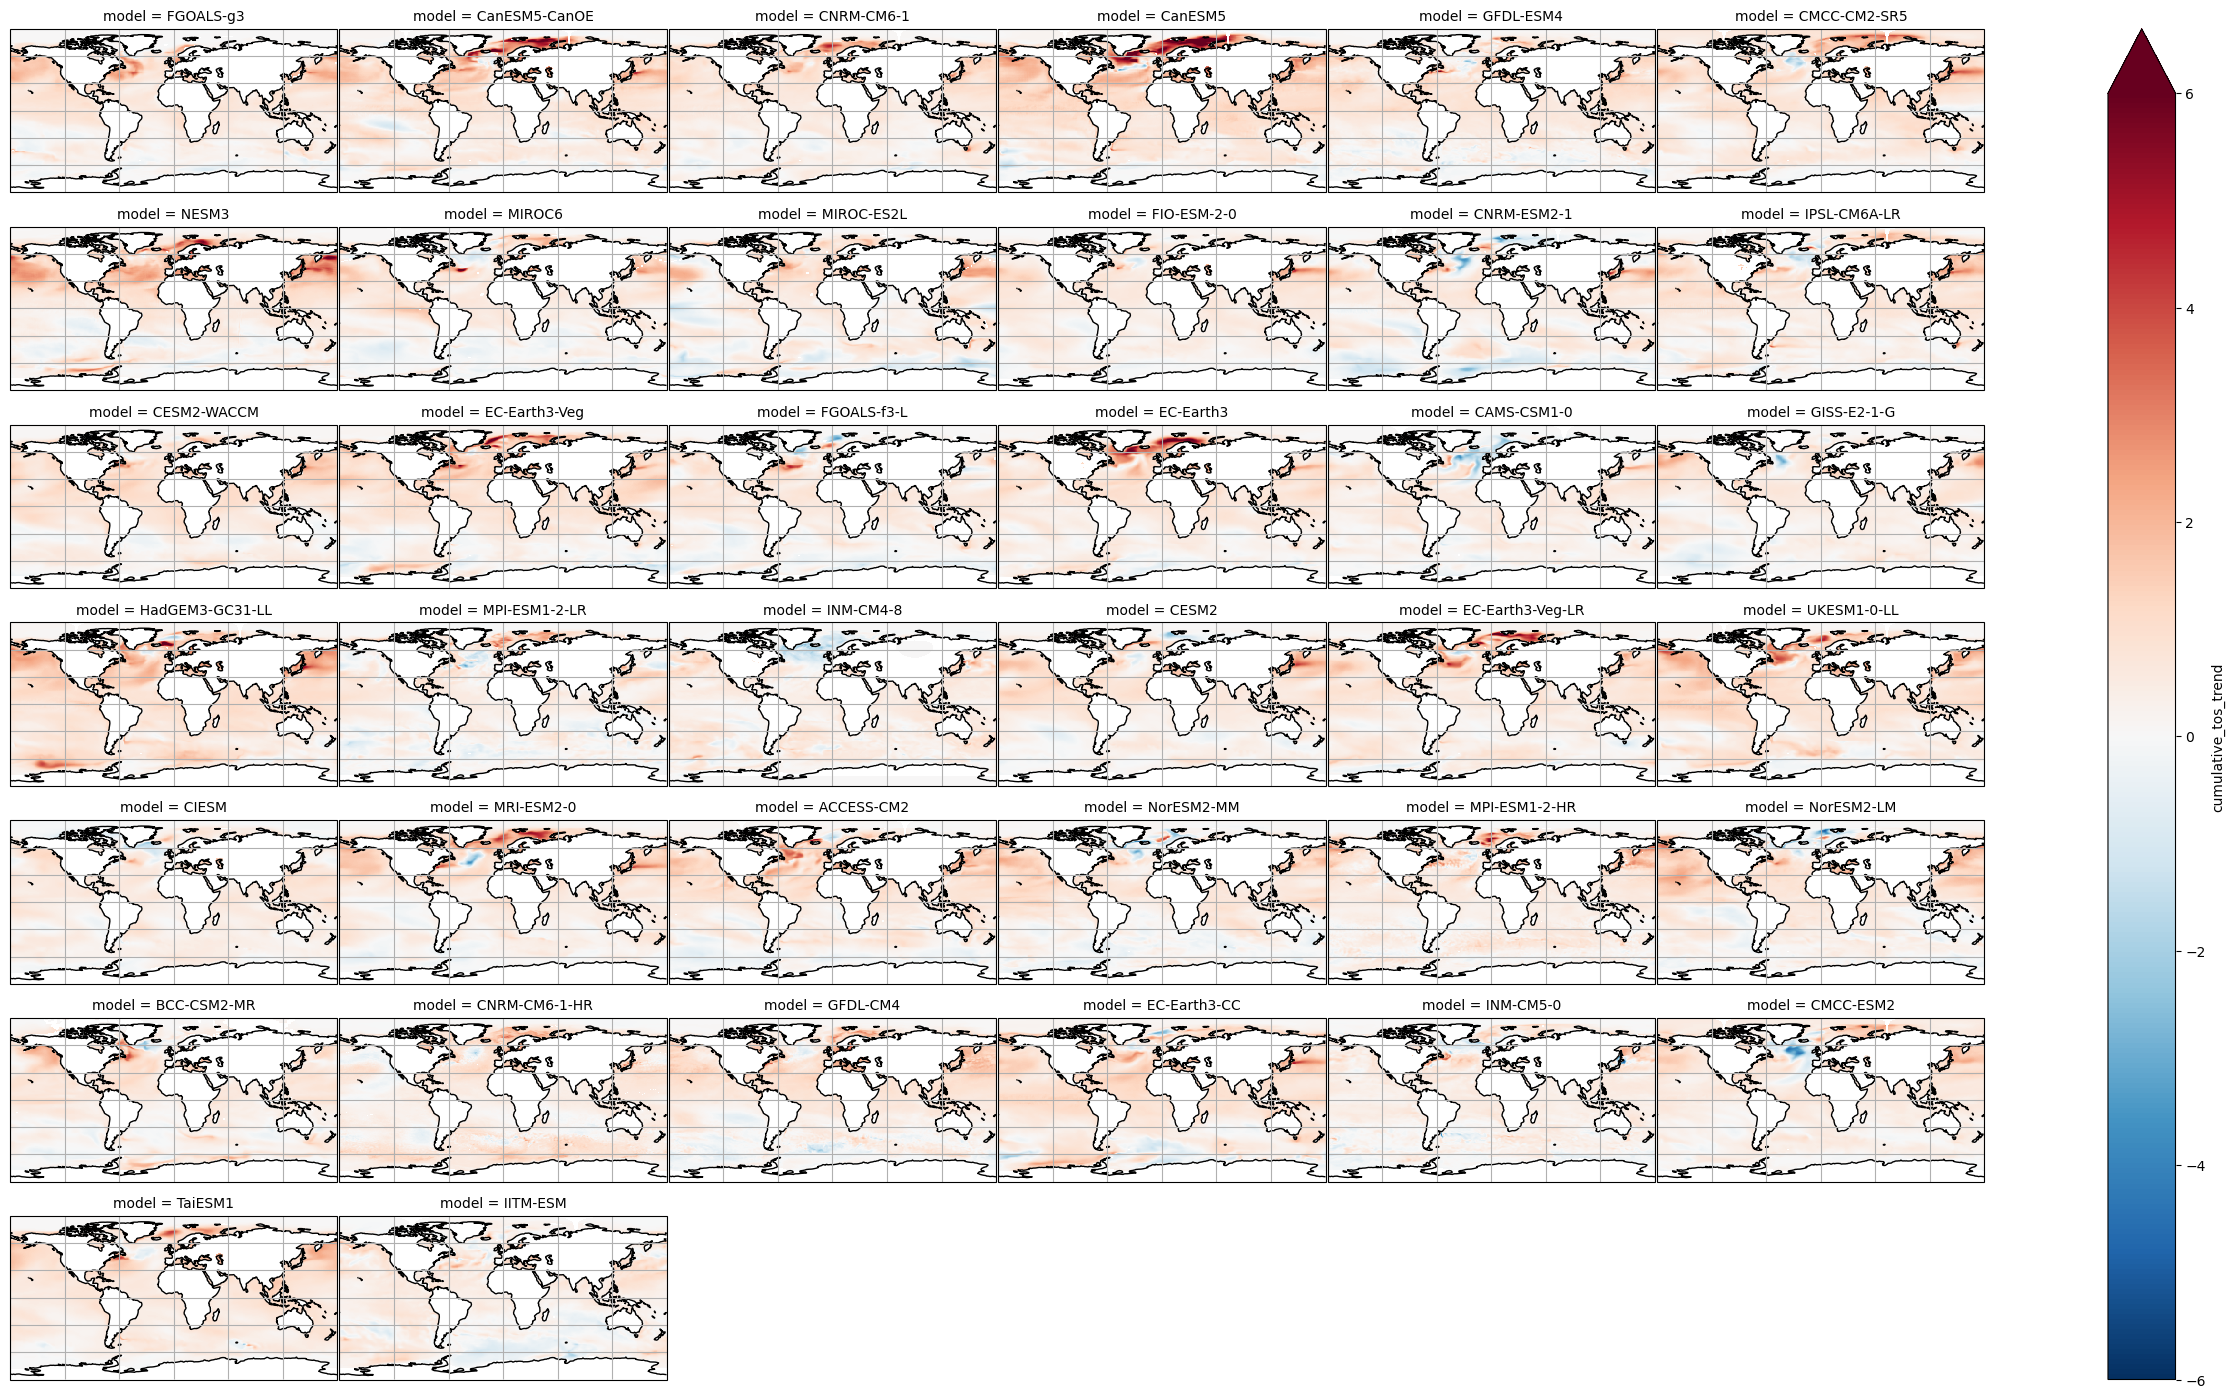

In [48]:
a = ds_merged_clean['cumulative_tos_trend'].plot(
    col='model',
    col_wrap=6,
    vmax=6,
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    x='lon',
    y='lat',
    transform=ccrs.PlateCarree(),
    size = 2, 
    aspect = 2,
)
for ax in a.axs.flat:
    ax.gridlines(draw_labels=False)
    ax.coastlines()

## Plot mean trend maps with different model selections according to the Hausfather et al. 2022 screening

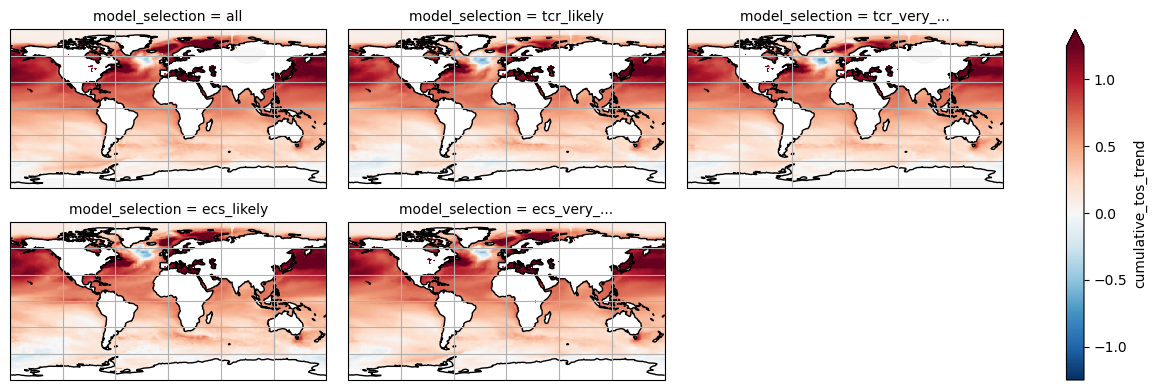

In [57]:
a = ds_mean['cumulative_tos_trend'].plot(
    col='model_selection', 
    col_wrap=3,
    vmax=1.25,
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    x='lon',
    y='lat',
    transform=ccrs.PlateCarree(),
    size = 2, 
    aspect = 2,
)
for ax in a.axs.flat:
    ax.gridlines(draw_labels=False)
    ax.coastlines()

## How different is the trend from taking an average over all models?

In [54]:
ds_anomaly = ds_mean.drop_sel(model_selection='all') - ds_mean.sel(model_selection='all')
ds_anomaly

<xarray.Dataset>
Dimensions:               (y: 180, x: 360, model_selection: 4)
Coordinates:
    lat                   (y, x) float64 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon                   (y, x) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * model_selection       (model_selection) <U15 'tcr_likely' ... 'ecs_very_l...
Dimensions without coordinates: y, x
Data variables:
    cumulative_tos_trend  (model_selection, y, x) float64 nan nan ... 0.01312

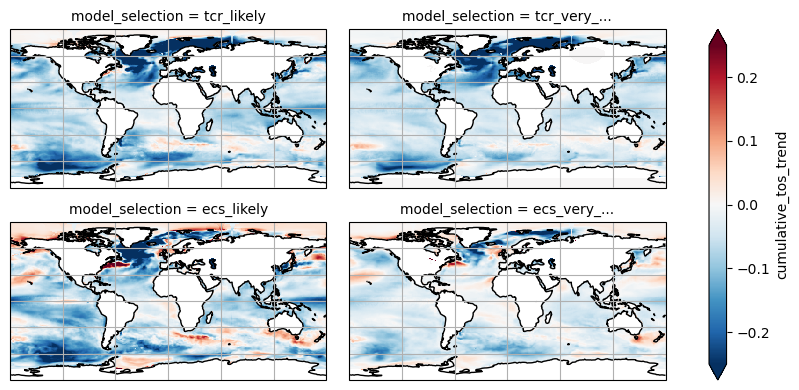

In [59]:
a = ds_anomaly['cumulative_tos_trend'].plot(
    col='model_selection', 
    col_wrap=2,
    vmax=0.25,
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    x='lon',
    y='lat',
    transform=ccrs.PlateCarree(),
    size = 2, 
    aspect = 2,
)
for ax in a.axs.flat:
    ax.gridlines(draw_labels=False)
    ax.coastlines()

## Older mean plot

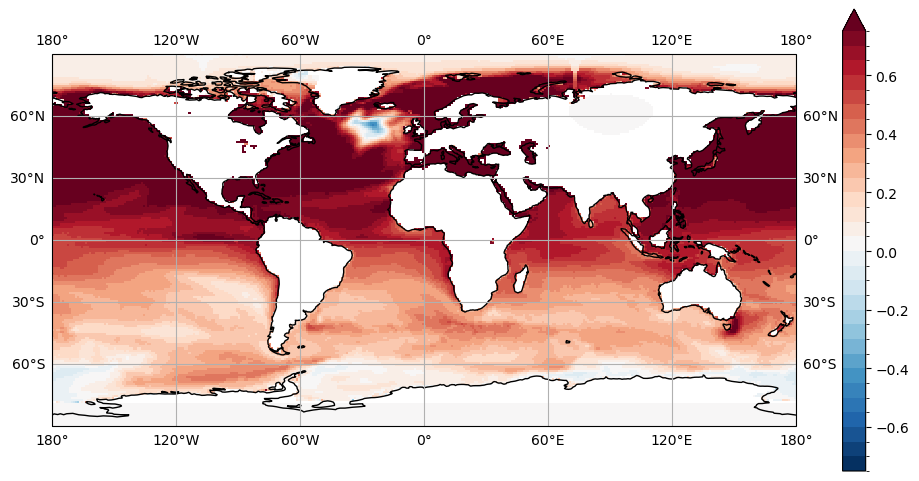

In [71]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=[12,6])
ds_merged_clean.mean('model').plot(vmax=0.75, x='lon', y='lat', transform=ccrs.PlateCarree(), levels=31)
ax.gridlines(draw_labels=True)
ax.coastlines()